# LLM Matrix/Grid Output Format Analysis using LM Studio API

This notebook queries the LM Studio API to generate numeric grids in response to various prompt configurations. It then parses the responses, categorizing them primarily into:

1.  **Python List Format:** Detects `[[...], [...]` structures.
2.  **Space/Newline Block Format:** Detects blocks of numbers separated by spaces and newlines.
3.  **Fallback Numeric Extraction:** Extracts numbers sequentially when specific structures aren't detected.

We also handle cases where the output is found within code blocks (```...```) and identify API errors or unparseable responses. Finally, we analyze and visualize the distribution of these formats across prompt configurations.

In [167]:
import json
import re
import time
import requests
import numpy as np
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm

# DEBUG flag can be set to True for verbose output during parsing
DEBUG = False

# LM Studio API configuration
LMSTUDIO_API_BASE_URL = "http://127.0.0.1:1234/v1"
# IMPORTANT: Replace with the actual model identifier loaded in your LM Studio
MODEL_IDENTIFIER = "loaded-model-identifier-here"  

def query_lm_studio(messages, temperature=0.7, max_tokens=1024):
    """ Sends a POST request to the LM Studio API chat/completions endpoint and returns the content and full JSON response. """
    url = f"{LMSTUDIO_API_BASE_URL}/chat/completions"
    headers = {"Content-Type": "application/json"}
    payload = {
        "model": MODEL_IDENTIFIER,
        "messages": messages,
        "temperature": temperature,
        "max_tokens": max_tokens,
        "stream": False
    }
    try:
        # Increased timeout for potentially larger models/responses
        response = requests.post(url, headers=headers, json=payload, timeout=300) 
        response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)
        resp_json = response.json()
        
        # Standard OpenAI API response structure check
        content = None
        if resp_json.get('choices') and len(resp_json['choices']) > 0:
            message = resp_json['choices'][0].get('message')
            if message and isinstance(message, dict):
                content = message.get('content')
                
        if content is None:
            print(f"Warning: Could not extract content. Full response: {resp_json}")
            return None, resp_json # Return None content but the response for inspection
            
        return content.strip(), resp_json
        
    except requests.exceptions.Timeout:
        print(f"Error: Request timed out connecting to {url}")
        return None, None
    except requests.exceptions.RequestException as e:
        print(f"Error connecting to LM Studio server at {url}: {e}")
        # Check if the model identifier is correct or if the server is running
        if MODEL_IDENTIFIER == "loaded-model-identifier-here":
             print("Hint: Make sure you've replaced 'loaded-model-identifier-here' with your actual model ID.")
        return None, None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON response: {e}")
        print(f"Raw response text (first 500 chars): {response.text[:500]}...")
        return None, None
    except Exception as e:
        # Catch any other unexpected errors during the API call
        print(f"An unexpected error occurred during API call: {e}")
        # Include the response object if available for debugging
        full_response = None
        if 'response' in locals() and response is not None:
            try:
                full_response = response.json()
            except json.JSONDecodeError:
                 full_response = response.text # Fallback to text if JSON decoding fails
        print(f"Full response (if available): {full_response}")
        return None, None

In [168]:
# --- Experiment Parameters ---
prompt_terms = ["matrix", "grid"]
dimensions_to_test = [
    (3, 3),
    (5, 5),
    (7, 4)
]
num_trials_per_config = 5 # Reduced for quicker testing, increase for more robust results
api_temperature = 0.5
api_max_tokens = 1500

print("Parameters:")
print(f"- Prompt Terms: {prompt_terms}")
print(f"- Dimensions: {dimensions_to_test}")
print(f"- Trials per configuration: {num_trials_per_config}")
print(f"- Model Identifier: {MODEL_IDENTIFIER}")

Parameters:
- Prompt Terms: ['matrix', 'grid']
- Dimensions: [(3, 3), (5, 5), (7, 4)]
- Trials per configuration: 5
- Model Identifier: loaded-model-identifier-here


In [169]:
def run_experiment_no_delay():
    """Runs the experiment over all configurations using the LM Studio API (no delay between calls)."""
    experiment_runs = []
    run_id_counter = 0
    total_runs = len(prompt_terms) * len(dimensions_to_test) * num_trials_per_config

    print(f"--- Starting Experiment: {total_runs} API calls planned (No Delay) ---")
    if MODEL_IDENTIFIER == "loaded-model-identifier-here":
        print("\n*** WARNING: MODEL_IDENTIFIER is set to placeholder. Experiment will likely fail. ***")
        print("*** Please edit the first code cell and set MODEL_IDENTIFIER to your loaded model. ***\n")
        
    start_time = time.time()
    # Use TQDM for progress bar
    pbar = tqdm(total=total_runs, desc="API Calls", unit="call", smoothing=0.1)

    for term in prompt_terms:
        for rows, cols in dimensions_to_test:
            for trial in range(num_trials_per_config):
                run_id_counter += 1
                # Use pbar.set_description for dynamic updates if needed, print less often
                # print(f"\nRunning Trial {run_id_counter}/{total_runs}: Term='{term}', Size={rows}x{cols}, Trial={trial+1}")
                prompt_text = f"Create a {term} structure consisting of {rows}x{cols} numbers."
                # print(f"  Prompt: {prompt_text}")
                
                messages = [{"role": "user", "content": prompt_text}]
                
                call_start_time = time.time()
                llm_response_content, llm_full_response = query_lm_studio(
                    messages,
                    temperature=api_temperature,
                    max_tokens=api_max_tokens
                )
                call_duration = time.time() - call_start_time
                
                run_data = {
                    "run_id": run_id_counter,
                    "term": term,
                    "rows": rows,
                    "cols": cols,
                    "trial_num": trial + 1,
                    "prompt_messages": messages,
                    "full_prompt_text": prompt_text,
                    "llm_response_raw": llm_response_content, # Store raw content for parsing
                    "llm_full_response_json": llm_full_response, # Store full API response
                    "api_call_duration_s": round(call_duration, 2),
                    "parsed_data": None, # To be filled by analysis step
                    "detected_format": "unknown", # To be filled by analysis step
                    "parse_success": None, # To be filled by analysis step
                    "parse_error": None # To be filled by analysis step
                }
                
                if llm_response_content is None:
                    # Update status if API call failed to get content
                    run_data['detected_format'] = "api_error"
                    run_data['parse_success'] = False
                    run_data['parse_error'] = "API call failed or returned no content."
                    # Log the error to the console for immediate feedback
                    tqdm.write(f"Trial {run_id_counter}: API Error ({call_duration:.2f}s) - Check LM Studio server and model ID.")

                experiment_runs.append(run_data)
                pbar.update(1) # Update progress bar
                # Optional short delay to avoid overwhelming the server if needed
                # time.sleep(0.1)
    
    pbar.close()
    total_duration = time.time() - start_time
    successful_calls = sum(1 for run in experiment_runs if run['llm_response_raw'] is not None)
    failed_calls = total_runs - successful_calls
    avg_duration = total_duration / total_runs if total_runs > 0 else 0
    
    print(f"\n--- Experiment Finished --- ")
    print(f"Total Runs: {total_runs}")
    print(f"Successful API Calls (got content): {successful_calls}")
    print(f"Failed API Calls (no content): {failed_calls}")
    print(f"Total Duration: {total_duration:.2f}s")
    print(f"Average Duration per Call: {avg_duration:.2f}s")
    
    return experiment_runs

# --- Run the Experiment --- 
# Ensure LM Studio is running with the correct model loaded before uncommenting!
experiment_results = run_experiment_no_delay()


--- Starting Experiment: 30 API calls planned (No Delay) ---

*** WARNING: MODEL_IDENTIFIER is set to placeholder. Experiment will likely fail. ***
*** Please edit the first code cell and set MODEL_IDENTIFIER to your loaded model. ***



API Calls: 100%|██████████| 30/30 [01:31<00:00,  3.04s/call]


--- Experiment Finished --- 
Total Runs: 30
Successful API Calls (got content): 30
Failed API Calls (no content): 0
Total Duration: 91.18s
Average Duration per Call: 3.04s


In [170]:
def parse_llm_response(raw_response, expected_rows, expected_cols):
    """ 
    Main parser entry point. 
    Checks for code blocks first, then delegates to inner parser.
    Categorizes results into simplified formats: list, block, fallback, or error/unparseable.
    """
    if not raw_response or not isinstance(raw_response, str):
        return None, "no_response_or_invalid", False, "Raw response is None, empty, or not a string."

    if DEBUG:
        print(f"\n--- Parsing Run --- R:{expected_rows} C:{expected_cols} ---")
        print(f"DEBUG: Raw Response (first 300 chars):\n{raw_response[:300]}...")

    # Basic check for refusal or explanation before attempting complex parsing
    # Look for keywords indicating inability or explanation instead of data
    # Also check if digit count is extremely low relative to expected size
    digit_count = sum(c.isdigit() for c in raw_response)
    if digit_count < (expected_rows * expected_cols * 0.5): # Heuristic: need at least half the expected digits
        # Check common refusal patterns (case-insensitive)
        refusal_patterns = ["sorry", "cannot create", "unable to", "can't generate", "I am an AI", "as an AI"]
        if any(pattern in raw_response.lower() for pattern in refusal_patterns):
            return None, "refusal_or_explanation", False, "Response seems to be a refusal or explanation."
        # If very few digits and no refusal pattern, it might be just text
        if digit_count == 0:
             return None, "text_only", False, "Response contained no digits."
        # If some digits but not enough, might still be explanation, let parsing try but keep this in mind
        if DEBUG: print(f"DEBUG: Low digit count ({digit_count}), might be explanation.")

    # Attempt to find and parse content within code blocks ```...```
    parsed_data = None
    detected_format = "unknown"
    parse_success = False
    parse_error = "Parsing did not succeed with any strategy."
    code_block_parsed = False
    final_parse_error_details = ""

    try:
        # Find all non-overlapping code blocks
        # Regex: ``` followed by optional language hint, newline, then content (non-greedy), ending with ```
        code_block_matches = re.findall(r'```(?:\w*\n)?([\s\S]*?)```', raw_response, re.DOTALL)
        
        if DEBUG: print(f"DEBUG: Found {len(code_block_matches)} code block(s).")
            
        if code_block_matches:
            # Prioritize the longest code block if multiple exist, as it's more likely the main data
            longest_block_content = max(code_block_matches, key=len).strip()
            
            if longest_block_content:
                if DEBUG: print(f"DEBUG: Attempting parse on longest code block content (first 100 chars): {longest_block_content[:100]}...")
                inner_data, inner_format, inner_success, inner_error = parse_llm_response_inner(
                    longest_block_content, expected_rows, expected_cols
                )
                if inner_success:
                    # Prepend 'code_block_' to the detected format
                    detected_format = f"code_block_{inner_format}"
                    parsed_data = inner_data
                    parse_success = True
                    parse_error = None # Success
                    code_block_parsed = True # Flag that we succeeded via code block
                    if DEBUG: print(f"DEBUG: Success parsing code block as {detected_format}")
                else:
                    # Store error from inner parsing attempt for potential reporting
                    final_parse_error_details = f"Code block found, but inner parse failed: {inner_error}"
                    if DEBUG: print(f"DEBUG: Code block inner parse failed: {inner_error}")
            else:
                final_parse_error_details = "Code block found, but it was empty after stripping."
                if DEBUG: print("DEBUG: Code block found but was empty.")

    except Exception as e:
        # Catch errors during the code block finding/processing itself
        final_parse_error_details = f"Error during code block processing: {e}"
        if DEBUG: print(f"DEBUG: Error processing code blocks: {e}")
        pass # Continue to parse the whole response if code block parsing fails

    # If parsing within a code block didn't succeed, attempt parsing the entire raw response
    if not code_block_parsed:
        if DEBUG: print("DEBUG: No success from code block, parsing entire response.")
        parsed_data, detected_format, parse_success, inner_error = parse_llm_response_inner(
            raw_response, expected_rows, expected_cols
        )
        if not parse_success:
            # Combine errors if both code block attempt and full parse attempt failed
            if final_parse_error_details:
                parse_error = f"{final_parse_error_details} | Full response parse also failed: {inner_error}"
            else:
                parse_error = inner_error # Error from the full parse attempt
        else:
             parse_error = None # Success
             if DEBUG: print(f"DEBUG: Success parsing full response as {detected_format}")
        
    # Final check on parsed data dimensions if parsing was successful
    if parse_success and isinstance(parsed_data, np.ndarray):
        if parsed_data.shape != (expected_rows, expected_cols):
            parse_error = f"Parsing yielded data, but shape {parsed_data.shape} doesn't match expected ({expected_rows}, {expected_cols}). Format was '{detected_format}'."
            if DEBUG: print(f"DEBUG: Shape mismatch warning - {parse_error}")
            # Decide if this counts as success: Maybe only fallback is allowed shape mismatch?
            if not detected_format.endswith("fallback_numeric_extraction"):
                 parse_success = False
                 detected_format = "parse_shape_mismatch"
                 # Keep parsed_data for inspection if needed, or set to None
                 # parsed_data = None 
            else:
                 # Allow fallback to have shape mismatch but note it
                 parse_error = f"Fallback successful but shape {parsed_data.shape} != ({expected_rows}, {expected_cols}) noted."
                 if DEBUG: print(f"DEBUG: Fallback shape mismatch noted.")
                 # Keep success True for fallback
                 
    # Convert numpy array to list for JSON serialization if successful
    final_data = parsed_data.tolist() if isinstance(parsed_data, np.ndarray) else parsed_data

    return final_data, detected_format, parse_success, parse_error


def parse_llm_response_inner(content_to_parse, expected_rows, expected_cols):
    """
    Inner parsing function with simplified strategies:
    1. Python List of Lists (using ast.literal_eval)
    2. Space/Newline Separated Block
    3. Fallback Numeric Extraction
    Returns: (parsed_data, detected_format, success_flag, error_message)
    """
    content_to_parse = content_to_parse.strip()
    lines = content_to_parse.splitlines()
    if DEBUG:
        print(f"DEBUG (Inner): Parsing {len(lines)} lines. First few: {lines[:5]}")

    # --- Strategy 1: Python List of Lists --- 
    try:
        # Find the most likely list-of-lists structure. Avoid matching simple lists.
        # Regex: A list `[...]` that contains at least one inner list `[...]`.
        # It looks for patterns like [[...],[...]] potentially spanning multiple lines.
        # Using re.DOTALL to match across newlines.
        list_matches = re.findall(r'(\[\s*(?:\[(?:.*?)\]\s*,?\s*)+\])', content_to_parse, re.DOTALL)
        
        if DEBUG: print(f"DEBUG (Inner): Found {len(list_matches)} potential Python list-of-lists matches.")
        
        if list_matches:
            # Select the longest match as it's most likely the intended full structure
            best_match = max(list_matches, key=len)
            if DEBUG: print(f"DEBUG (Inner): Trying ast.literal_eval on longest match (len {len(best_match)}): {best_match[:100]}...")

            # Attempt to parse the best match using ast.literal_eval for safety
            try:
                potential_data = ast.literal_eval(best_match)
                
                # Validate the parsed structure
                if (isinstance(potential_data, list) and 
                    len(potential_data) == expected_rows and 
                    all(isinstance(row, list) for row in potential_data) and 
                    all(len(row) == expected_cols for row in potential_data) and 
                    all(isinstance(el, (int, float)) for row in potential_data for el in row)):
                    
                    # Convert floats to ints if they are whole numbers
                    int_data = [[int(el) if isinstance(el, float) and el.is_integer() else el for el in row] for row in potential_data]
                    
                    # Final check: ensure all elements are now integers
                    if all(isinstance(el, int) for row in int_data for el in row):
                        if DEBUG: print("DEBUG (Inner): Success with python_list strategy.")
                        return np.array(int_data), "python_list", True, None
                    else:
                         if DEBUG: print("DEBUG (Inner): Python list parsed but contains non-integers after conversion.")
                else:
                    if DEBUG:
                        print("DEBUG (Inner): ast.literal_eval result failed validation (type/shape/content). ", 
                              f"Got type {type(potential_data)}, len {len(potential_data) if isinstance(potential_data, list) else 'N/A'}")
            except (ValueError, SyntaxError, TypeError) as e:
                # Handle cases where literal_eval fails
                if DEBUG: print(f"DEBUG (Inner): ast.literal_eval failed: {e}")
            except Exception as e:
                 if DEBUG: print(f"DEBUG (Inner): Unexpected error during Python list parsing: {e}")
                 
    except Exception as e:
        # Catch errors during the regex finding itself
        if DEBUG: print(f"DEBUG (Inner): Error finding Python list regex matches: {e}")
        pass # Continue to next strategy if regex or parsing fails

    # --- Strategy 2: Space/Newline Separated Block --- 
    try:
        numeric_lines = []
        potential_start_found = False
        lines_processed_for_block = 0
        
        for i, line in enumerate(lines):
            cleaned_line = line.strip()
            # Skip empty lines or lines that are clearly separators/markdown
            if not cleaned_line or re.match(r'^[|`\-=*#\[]', cleaned_line) or re.match(r'^[-|\s:]+$', cleaned_line):
                 # If we already started finding numeric lines, a separator might mean the end of the block
                 if potential_start_found and len(numeric_lines) >= expected_rows:
                     if DEBUG: print(f"DEBUG (Inner): Block strategy stopped by separator line: {cleaned_line}")
                     break 
                 continue # Skip this line

            # Remove potential leading list markers or numbering (e.g., '1. ', '- ')
            cleaned_line = re.sub(r'^\s*[-\*]?\s*\d+[:.)]?\s*', '', cleaned_line)
            # Remove brackets, pipes, commas - treat them as potential delimiters
            cleaned_line = re.sub(r'[,\[\]\|]', ' ', cleaned_line)
            
            tokens = cleaned_line.split()

            # Check if the line consists only of numbers after splitting
            if tokens and all(re.fullmatch(r'-?\d+', token) for token in tokens):
                numeric_lines.append([int(t) for t in tokens])
                potential_start_found = True
                lines_processed_for_block += 1
                # Stop if we have enough rows, prevents grabbing trailing text
                if lines_processed_for_block >= expected_rows:
                    break
            elif potential_start_found:
                # If we started finding numeric lines and encounter a non-numeric one, assume the block ended.
                if DEBUG: print(f"DEBUG (Inner): Block strategy stopped by non-numeric line: {line.strip()}")
                break
        
        if DEBUG: print(f"DEBUG (Inner): Block strategy found {len(numeric_lines)} potential numeric lines.")

        # Validate the collected block
        if (len(numeric_lines) == expected_rows and 
            all(len(row) == expected_cols for row in numeric_lines)):
            if DEBUG: print("DEBUG (Inner): Success with space_newline_block strategy.")
            return np.array(numeric_lines), "space_newline_block", True, None
        else:
             if DEBUG: print("DEBUG (Inner): Block validation failed (row/col count mismatch).")

    except Exception as e:
        if DEBUG: print(f"DEBUG (Inner): Error during space/newline block parsing: {e}")
        pass # Continue to fallback

    # --- Strategy 3: Fallback Numeric Extraction --- 
    try:
        # Find all sequences of digits (potentially with a leading minus sign)
        all_numbers = re.findall(r'-?\d+', content_to_parse)
        if DEBUG: print(f"DEBUG (Inner): Fallback strategy found {len(all_numbers)} numbers: {all_numbers[:20]}...")

        required_count = expected_rows * expected_cols
        if len(all_numbers) >= required_count:
            # Take the first N required numbers
            extracted_numbers = all_numbers[:required_count]
            # Reshape into the desired matrix/grid dimensions
            try:
                data = np.array([int(n) for n in extracted_numbers]).reshape((expected_rows, expected_cols))
                if DEBUG: print("DEBUG (Inner): Success with fallback_numeric_extraction strategy.")
                return data, "fallback_numeric_extraction", True, None
            except ValueError as e:
                if DEBUG: print(f"DEBUG (Inner): Fallback failed during int conversion or reshape: {e}")
                # Error during conversion or reshaping
                pass 
        else:
            if DEBUG: print(f"DEBUG (Inner): Fallback failed - not enough numbers found ({len(all_numbers)} < {required_count}).")
            
    except Exception as e:
        if DEBUG: print(f"DEBUG (Inner): Error during fallback numeric extraction: {e}")
        pass

    # If none of the strategies worked
    detected_format = "unparseable"
    error_msg = f"Inner Parse Failed: Could not parse content using list, block, or fallback strategies. Preview: {content_to_parse[:100]}"
    return None, detected_format, False, error_msg


In [171]:
def analyze_all_runs(experiment_runs):
    """Analyzes responses using the parser, updates runs, and returns a summary."""
    print("\n--- Analyzing Collected Responses ---")
    results_summary = {} 
    success_count = 0
    fail_count = 0

    if not experiment_runs:
        print("Warning: No experiment results found to analyze.")
        return {}
        
    # Use tqdm for analysis progress if many runs
    pbar_analyze = tqdm(experiment_runs, desc="Analyzing Runs", unit="run")

    for run in pbar_analyze:
        # Skip analysis if API call already failed
        if run.get('detected_format') == 'api_error':
            fail_count += 1
        else:
            # Call the main parser function
            parsed_data, detected_format, parse_success, parse_error = parse_llm_response(
                run['llm_response_raw'],
                run['rows'],
                run['cols']
            )
            # Update the run dictionary with parsing results
            run['parsed_data'] = parsed_data # Already converted to list or None by parser
            run['detected_format'] = detected_format
            run['parse_success'] = parse_success
            run['parse_error'] = parse_error
            
            if parse_success:
                success_count += 1
            else:
                fail_count += 1
                # Optionally log parsing failures for debugging
                # tqdm.write(f"Run {run['run_id']} Parse Failed: {detected_format} - {parse_error}")

        # Aggregate results by configuration
        config_key = f"Term='{run['term']}', Size={run['rows']}x{run['cols']}"
        if config_key not in results_summary:
            results_summary[config_key] = {'total': 0, 'success': 0, 'formats': {}}
        
        current_format = run['detected_format']
        results_summary[config_key]['formats'][current_format] = results_summary[config_key]['formats'].get(current_format, 0) + 1
        results_summary[config_key]['total'] += 1
        if run.get('parse_success'): # Check the success flag set by the parser
            results_summary[config_key]['success'] += 1

    print(f"\n--- Analysis Complete --- ")
    print(f"Total Runs Analyzed: {len(experiment_runs)}")
    print(f"Successful Parses: {success_count}")
    print(f"Failed Parses/Errors: {fail_count}")
    
    # --- Print Summary by Configuration --- 
    print("\n--- Analysis Summary by Configuration ---")
    # Sort configurations for consistent output order
    # Sort first by term, then by rows, then by columns
    def sort_key(item):
        config_str = item[0]
        match = re.match(r"Term='(.*?)', Size=(\d+)x(\d+)", config_str)
        if match:
            term, rows, cols = match.groups()
            return term, int(rows), int(cols)
        return config_str, 0, 0 # Fallback
    
    sorted_configs = sorted(results_summary.items(), key=sort_key)
    
    for config, summary in sorted_configs:
        success_rate = (summary['success'] / summary['total'] * 100) if summary['total'] > 0 else 0
        print(f"Configuration: {config} (Success: {summary['success']}/{summary['total']} = {success_rate:.1f}%)")
        # Sort formats by count descending for better readability
        sorted_formats = sorted(summary['formats'].items(), key=lambda item: item[1], reverse=True)
        for format_type, count in sorted_formats:
            # Use alignment for better readability
            print(f"  - Format: {format_type:<40} Count: {count}")
        print("") # Add a blank line between configurations
    
    return results_summary

def print_overview(results_summary):
    """ Prints a formatted overview of the results summary. """
    print("\n========== LLM Output Overview Summary ==========")
    if not results_summary:
        print("No summary data available to display.")
        print("==================================================")
        return
        
    # Use the same sorting as analyze_all_runs for consistency
    def sort_key(item):
        config_str = item[0]
        match = re.match(r"Term='(.*?)', Size=(\d+)x(\d+)", config_str)
        if match:
            term, rows, cols = match.groups()
            return term, int(rows), int(cols)
        return config_str, 0, 0 # Fallback
    sorted_summary = sorted(results_summary.items(), key=sort_key)

    for config, summary in sorted_summary:
        success_rate = (summary['success'] / summary['total'] * 100) if summary['total'] > 0 else 0
        print(f"\nConfiguration: {config}")
        print(f"  Total Runs: {summary['total']}")
        print(f"  Successful Parses: {summary['success']} ({success_rate:.1f}%)")
        print("  Output Format Distribution:")
        # Sort formats by count descending
        sorted_formats = sorted(summary['formats'].items(), key=lambda item: item[1], reverse=True)
        for fmt, count in sorted_formats:
            print(f"    {fmt:<40}: {count}")
    print("\n==================================================")

# --- Analyze Results --- 
# Check if experiment_results exist before analyzing
if 'experiment_results' in locals() and experiment_results:
    results_summary = analyze_all_runs(experiment_results)
    print_overview(results_summary)
else:
    print("\nNo experiment results found. Please run the experiment cell first.")
    results_summary = {} # Initialize as empty dictionary



--- Analyzing Collected Responses ---


Analyzing Runs: 100%|██████████| 30/30 [00:00<00:00, 4995.60run/s]


--- Analysis Complete --- 
Total Runs Analyzed: 30
Successful Parses: 30
Failed Parses/Errors: 0

--- Analysis Summary by Configuration ---
Configuration: Term='grid', Size=3x3 (Success: 5/5 = 100.0%)
  - Format: code_block_fallback_numeric_extraction   Count: 5

Configuration: Term='grid', Size=5x5 (Success: 5/5 = 100.0%)
  - Format: code_block_fallback_numeric_extraction   Count: 5

Configuration: Term='grid', Size=7x4 (Success: 5/5 = 100.0%)
  - Format: code_block_fallback_numeric_extraction   Count: 5

Configuration: Term='matrix', Size=3x3 (Success: 5/5 = 100.0%)
  - Format: code_block_python_list                   Count: 3
  - Format: code_block_fallback_numeric_extraction   Count: 1
  - Format: fallback_numeric_extraction              Count: 1

Configuration: Term='matrix', Size=5x5 (Success: 5/5 = 100.0%)
  - Format: code_block_python_list                   Count: 5

Configuration: Term='matrix', Size=7x4 (Success: 5/5 = 100.0%)
  - Format: code_block_python_list              


--- Visualizing Output Format Distributions ---


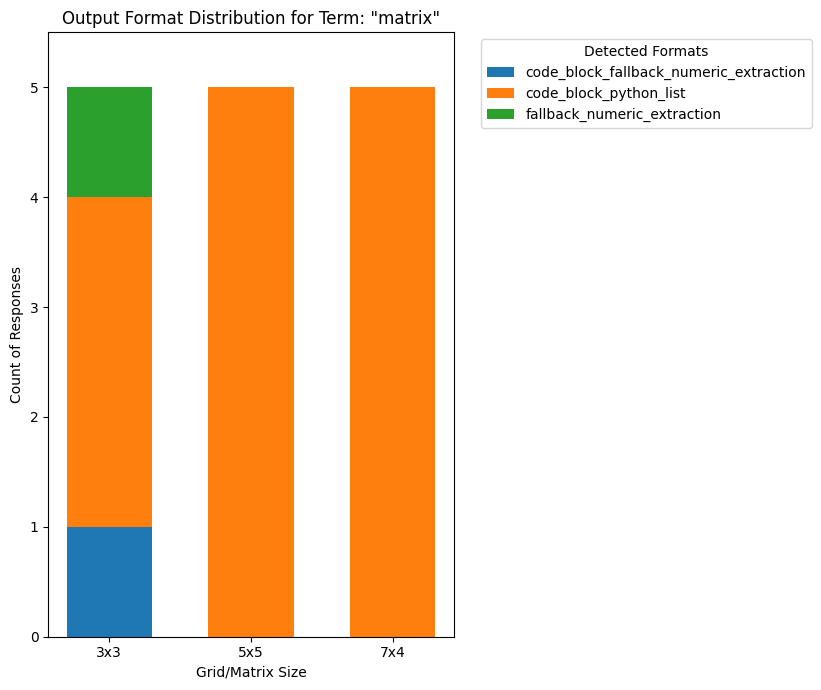

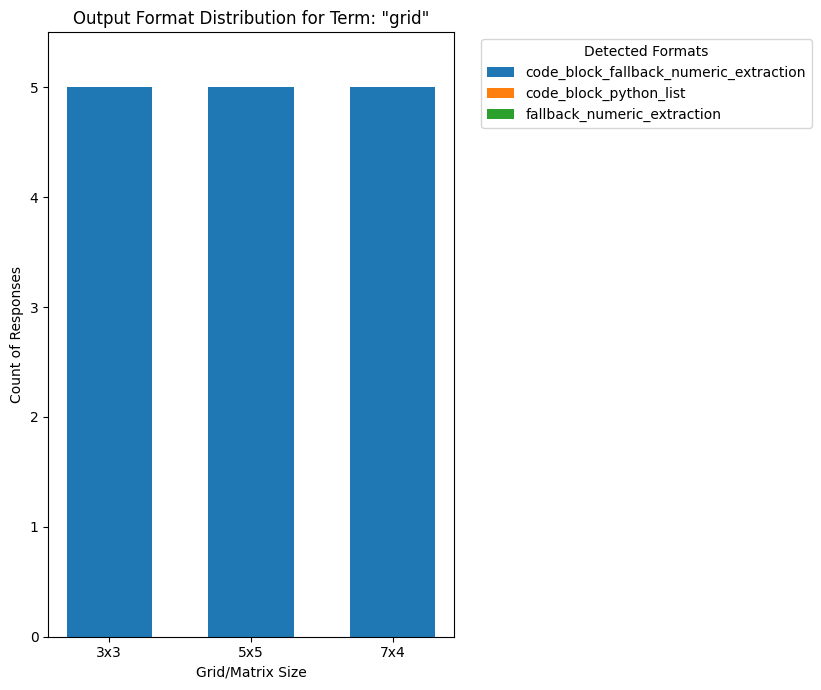

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import re

def visualize_output_distribution(results_summary):
    """ Creates bar charts visualizing the distribution of detected output formats for each term/size configuration. """
    print("\n--- Visualizing Output Format Distributions ---")
    
    if not results_summary:
        print("No summary data available to visualize.")
        return

    # Organize data for plotting: {term: {size: {format: count}}} 
    visual_data = {}
    all_format_types = set() # Keep track of all possible formats across all configs
    
    for config, summary in results_summary.items():
        # Extract term and size using regex for flexibility
        m = re.search(r"Term='(.*?)', Size=(\d+x\d+)", config)
        if m:
            term = m.group(1)
            size = m.group(2)
            if term not in visual_data:
                visual_data[term] = {}
            # Store the format counts for this size under this term
            visual_data[term][size] = summary['formats']
            # Update the set of all encountered format types
            all_format_types.update(summary['formats'].keys())
        else:
            print(f"Warning: Could not parse configuration string: {config}")

    # Sort the formats alphabetically for consistent legend order
    sorted_format_types = sorted(list(all_format_types))

    # Create a separate plot for each 'term' (e.g., 'matrix', 'grid')
    for term, size_data in visual_data.items():
        # Sort sizes based on row count, then column count for logical order
        def size_sort_key(s):
            rows, cols = map(int, s.split('x'))
            return rows, cols
        sizes = sorted(size_data.keys(), key=size_sort_key)
        
        # Prepare data for the bar chart
        counts = {fmt: [] for fmt in sorted_format_types}
        totals = [] # To calculate percentages if needed, or just for reference
        for size in sizes:
            size_total = sum(size_data[size].values())
            totals.append(size_total)
            for fmt in sorted_format_types:
                # Append the count for this format and size, default to 0 if format not present
                counts[fmt].append(size_data[size].get(fmt, 0))
        
        # Create the stacked bar chart
        x = np.arange(len(sizes)) # the label locations
        width = 0.6 # the width of the bars
        bottom = np.zeros(len(sizes)) # initialize bottom for stacking
        
        fig, ax = plt.subplots(figsize=(10, 7)) # Adjust figure size as needed
        
        for fmt in sorted_format_types:
            # Convert counts[fmt] list to numpy array for vectorized addition
            counts_array = np.array(counts[fmt])
            # Plot the bar for the current format, stacked on the previous ones
            rects = ax.bar(x, counts_array, width, label=fmt, bottom=bottom)
            # Add the counts of the current format to the bottom for the next stack
            bottom += counts_array

        # Add some text for labels, title and axes ticks
        ax.set_ylabel('Count of Responses')
        ax.set_xlabel('Grid/Matrix Size')
        ax.set_title(f'Output Format Distribution for Term: "{term}"')
        ax.set_xticks(x)
        ax.set_xticklabels(sizes)
        # Add a legend, place it outside the plot if too many formats
        ax.legend(title="Detected Formats", bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set y-axis to start at 0 and add some padding
        ax.set_ylim(bottom=0, top=max(bottom) * 1.1 if max(bottom) > 0 else 1)
        # Ensure y-axis ticks are integers if counts are integers
        ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()

# --- Visualize Results --- 
# Check if results_summary exists and is not empty
if 'results_summary' in locals() and results_summary:
    visualize_output_distribution(results_summary)
else:
    print("\nNo analysis summary found. Please run the analysis cell first.")


### Analysis of Results

Based on the experimental results, summary, and visualizations, we can draw conclusions about how the LLM formats numeric grid/matrix outputs under different conditions:

1.  **Dominant Formats:** Observe which formats (`python_list`, `space_newline_block`, `fallback_numeric_extraction`, or error/unparseable types) are most common for each prompt configuration (term + size).

2.  **Influence of Terminology ("matrix" vs. "grid"):**
   - Does using the term "matrix" significantly increase the likelihood of getting a `python_list` format compared to using "grid"?
   - Does "grid" lead more often to `space_newline_block` outputs?
   - Look for differences in the distribution patterns between the plots for "matrix" and "grid".

3.  **Effect of Dimensions:**
   - Does the requested size (e.g., 3x3 vs. 7x4) influence the output format? 
   - Are certain formats more likely for smaller or larger dimensions? 
   - Does the aspect ratio (e.g., square 5x5 vs. rectangular 7x4) matter?

4.  **Code Block Usage:**
   - How often does the LLM wrap its output in code blocks (``` ```)? 
   - Is the format *inside* the code block different from formats produced without code blocks?
   - Compare `code_block_python_list` vs `python_list`, etc.

5.  **Parser Robustness and Fallback:**
   - How often was the `fallback_numeric_extraction` needed? A high frequency suggests the LLM often produces formats not easily captured by the `python_list` or `space_newline_block` parsers, or that these parsers need further refinement.
   - Were there many `unparseable` results or errors like `refusal_or_explanation` or `text_only`? This indicates the LLM failed to fulfill the request directly.
   - Did any successful parses result in shape mismatches (`parse_shape_mismatch`)?

**Implications:**

*   **Prompt Engineering:** The results can guide how to phrase prompts to maximize the chance of getting a desired output format. If a machine-readable list is needed, using "matrix" might be better. If a human-readable block is preferred, "grid" might be more suitable.
*   **Downstream Processing:** Understanding the likely output formats helps in building robust downstream applications. Expecting and handling `python_list`, `space_newline_block`, and having a fallback mechanism seems necessary.

**Further Work:**

*   Test with different LLMs.
*   Increase `num_trials_per_config` for statistical significance.
*   Experiment with more detailed prompts (e.g., specifying output format explicitly, asking for specific number ranges).
*   Analyze the *content* of the parsed data (e.g., are the numbers random, sequential, patterned?).